### Install & Import Libraries

In [ ]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Formatting
from matplotlib.ticker import FuncFormatter

# Plot settings
plt.style.use('default')
sns.set(style="whitegrid")


1. **Library Imports:**
   This cell imports essential libraries like **pandas** and **numpy** for data handling, and **matplotlib** and **seaborn** for data visualization.

2. **Visualization & Formatting Setup:**
   It includes visualization tools and formatting utilities such as `FuncFormatter` to customize axis labels and improve plot readability.

3. **Global Plot Styling:**
   Default plotting styles are configured using Matplotlib and Seaborn to ensure all graphs have a clean, consistent, and visually appealing appearance throughout the notebook.


### Load Datasets

In [ ]:
# Load datasets (uploaded to Colab)
demographic = pd.read_csv('demographic_new.csv')
enrollment = pd.read_csv('enrollment_new.csv')

print("Demographic shape:", demographic.shape)
print("Enrollment shape:", enrollment.shape)


Demographic shape: (1041315, 6)
Enrollment shape: (1006007, 7)


1. **Dataset Loading:**
   This cell loads the cleaned CSV files (`demographic_new.csv` and `enrollment_new.csv`) into Pandas DataFrames for further analysis.

2. **Data Cleaning & Standardization:**
   During preprocessing, **state and district names were standardized and corrected** to ensure uniform naming across **all three datasets**, enabling accurate merging and comparison.


### Common Preprocessing

In [ ]:
# ----- Demographic preprocessing -----
demographic['total_population'] = (
    demographic['demo_age_5_17'] + demographic['demo_age_17_']
)

demographic['date'] = pd.to_datetime(
    demographic['date'], format='%d-%m-%Y', errors='coerce'
)
demographic['month'] = demographic['date'].dt.month
demographic['month_name'] = demographic['date'].dt.strftime('%b')

# ----- Enrollment preprocessing -----
enrollment['date'] = pd.to_datetime(
    enrollment['date'], format='%d-%m-%Y', errors='coerce'
)
enrollment['month'] = enrollment['date'].dt.to_period('M')
enrollment['total_enrollment'] = (
    enrollment['age_0_5'] +
    enrollment['age_5_17'] +
    enrollment['age_18_greater']
)


1. **Demographic Feature Engineering:**
   A new feature `total_population` is created by aggregating relevant age-group columns, and the date column is converted to a proper datetime format to enable time-based analysis.

2. **Temporal Data Extraction:**
   Month-related features (`month` and `month_name`) are extracted from the date field to support monthly trend analysis and temporal grouping.

3. **Enrollment Data Preprocessing:**
   The enrollment dataset undergoes similar date standardization, and a new `total_enrollment` feature is computed by summing enrollments across all age categories, ensuring consistency with demographic data for comparative analysis.


### Helper Function (Indian Number Format)


In [ ]:
def format_indian(x, pos=None):
    if x >= 1e7:
        return f'{x/1e7:.1f}Cr'
    elif x >= 1e5:
        return f'{x/1e5:.1f}L'
    return f'{int(x)}'


1. **Custom Number Formatting:**
   This helper function formats large numeric values according to the **Indian numbering system**, improving readability in plots and summaries.

2. **Scale-Based Representation:**
   Values are automatically converted to **Crores (Cr)** or **Lakhs (L)** based on their magnitude, while smaller numbers are displayed as integers.

3. **Visualization Support:**
   The function is designed to be used with Matplotlib axis formatters, ensuring consistent and region-appropriate number formatting across all visualizations.


### Top 10 Most Populated States (Age-wise)

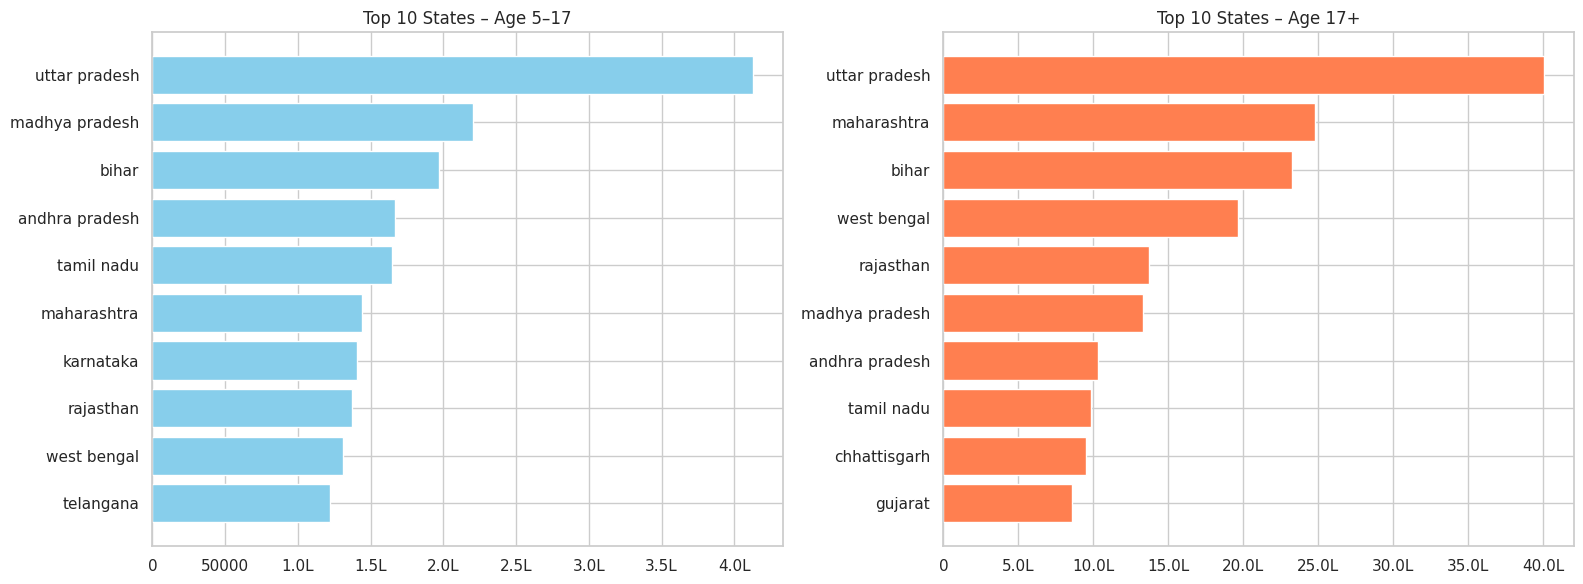

In [ ]:
state_pop = demographic.groupby('state')[[
    'demo_age_5_17', 'demo_age_17_'
]].sum().reset_index()

top_5_17 = state_pop.nlargest(10, 'demo_age_5_17')
top_17_plus = state_pop.nlargest(10, 'demo_age_17_')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.barh(top_5_17['state'], top_5_17['demo_age_5_17'], color='skyblue')
ax1.set_title('Top 10 States – Age 5–17')
ax1.xaxis.set_major_formatter(FuncFormatter(format_indian))
ax1.invert_yaxis()

ax2.barh(top_17_plus['state'], top_17_plus['demo_age_17_'], color='coral')
ax2.set_title('Top 10 States – Age 17+')
ax2.xaxis.set_major_formatter(FuncFormatter(format_indian))
ax2.invert_yaxis()

plt.tight_layout()
plt.show()


1. **State-wise Population Aggregation:**
   The demographic data is grouped by state and aggregated to compute total populations for the **5–17** and **17+** age groups, after which the **top 10 states** in each category are identified.

2. **Comparative Visualization:**
   Two horizontal bar charts are plotted side by side to compare the top states across age groups, using the **Indian number formatter** for readability and inverted axes to highlight highest values at the top.


### Top 5 Districts of Top 10 States


/tmp/ipython-input-1117547037.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(5, 'total_population')) \


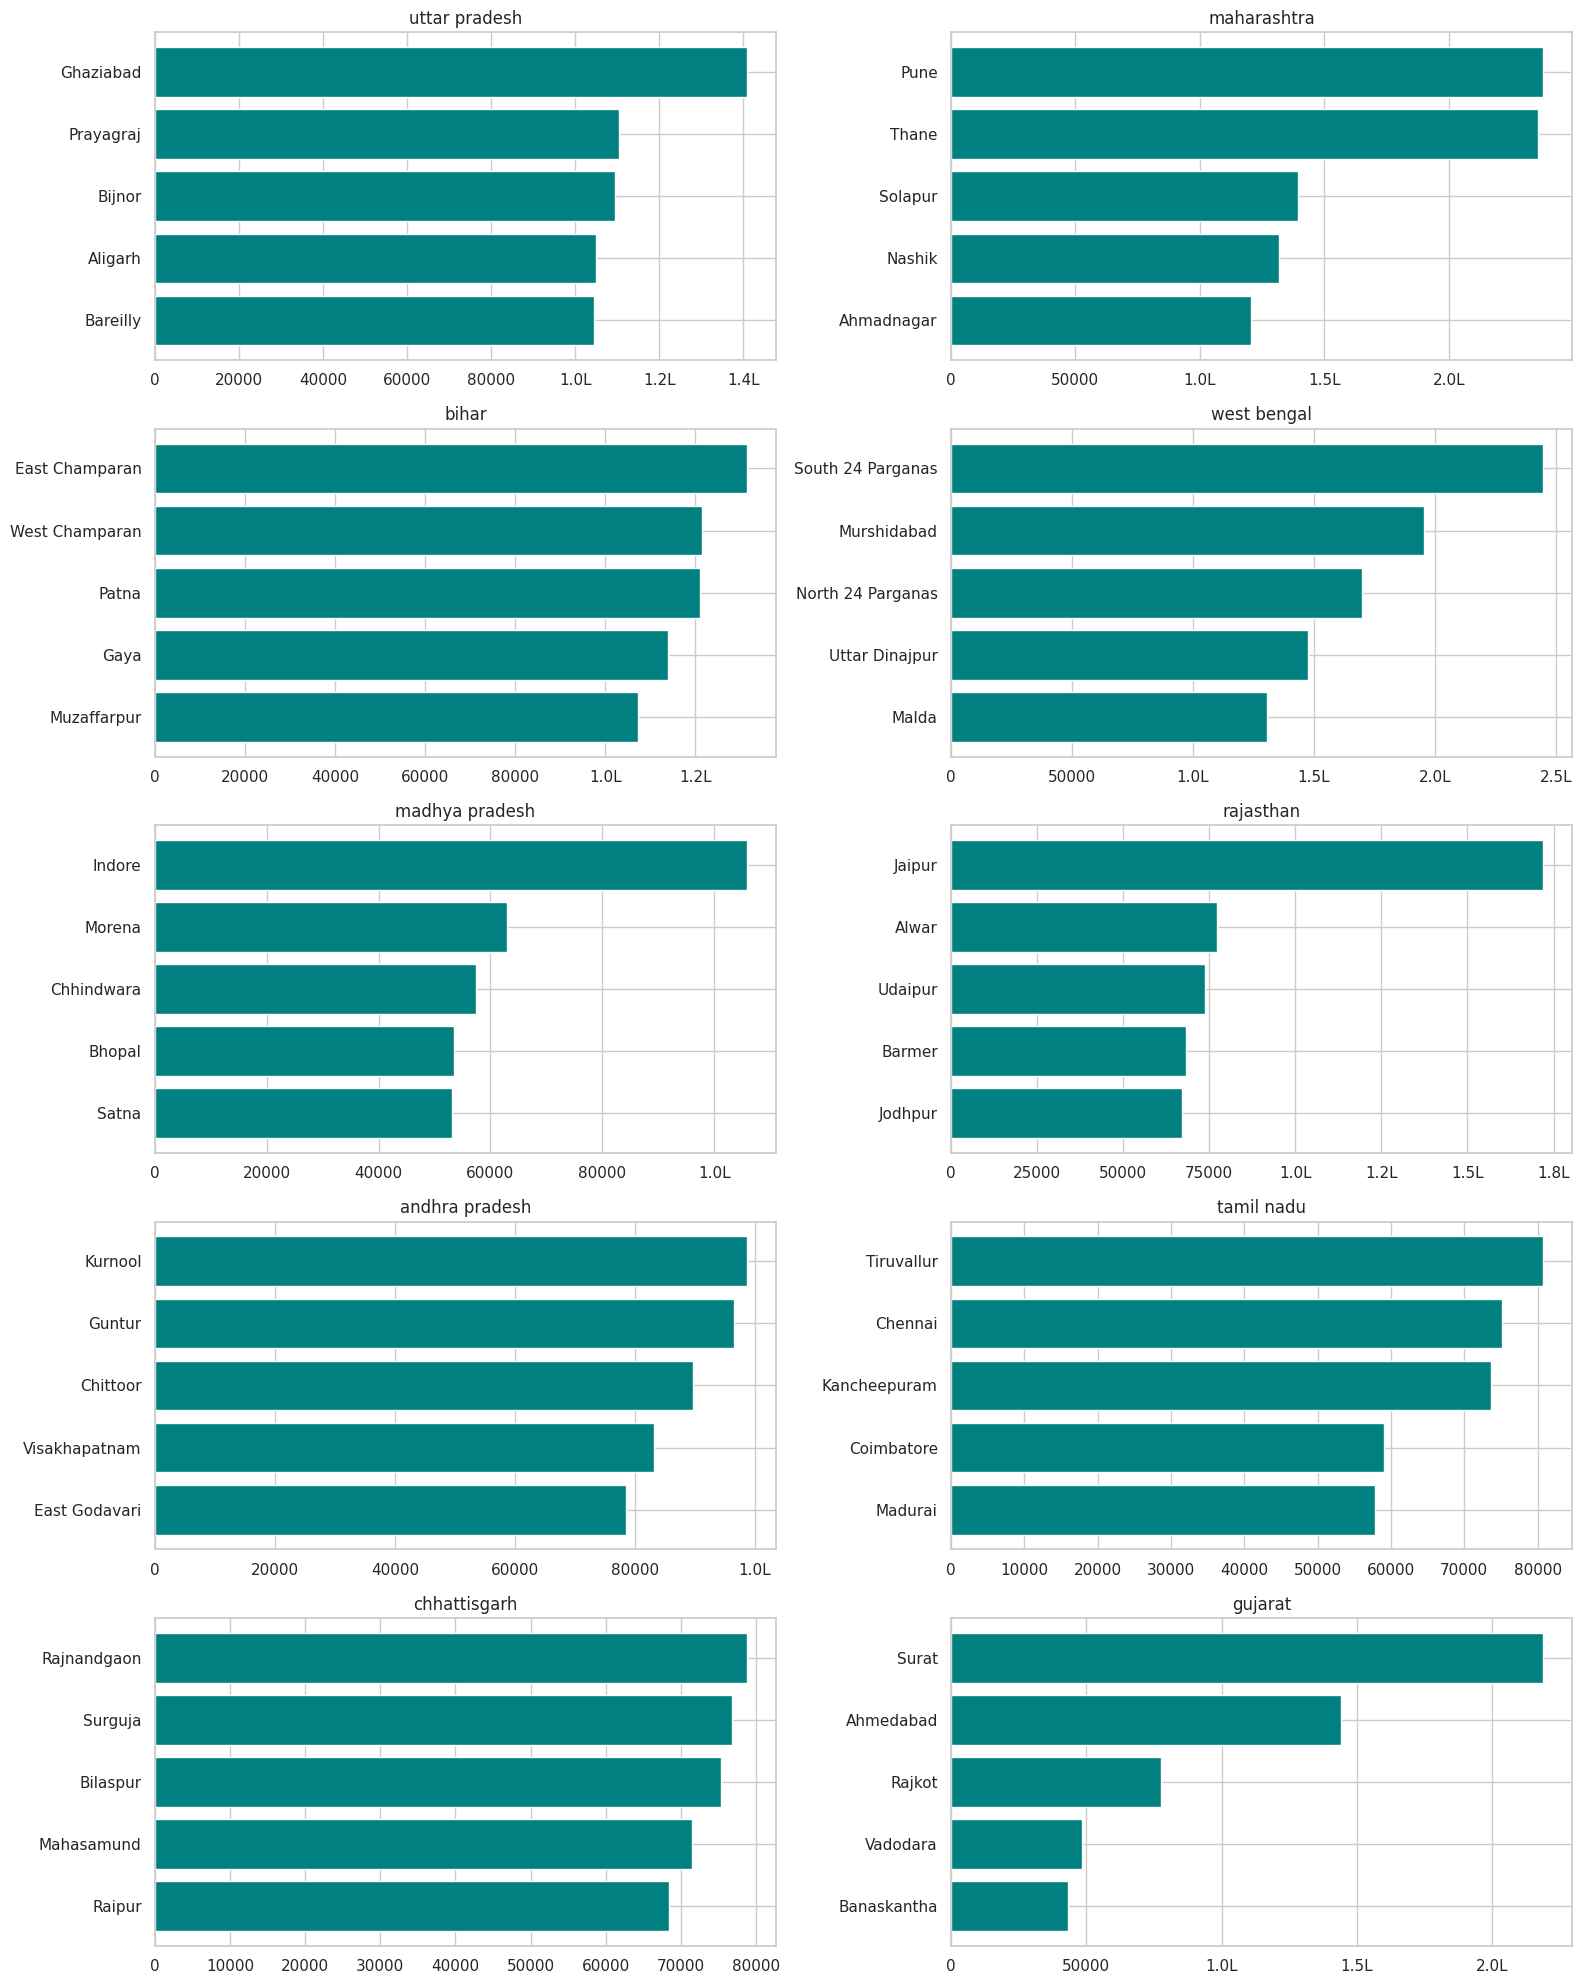

In [ ]:
state_total = demographic.groupby('state')['total_population'].sum().reset_index()
top_states = state_total.nlargest(10, 'total_population')['state']

district_agg = demographic[demographic['state'].isin(top_states)] \
    .groupby(['state', 'district'])['total_population'].sum().reset_index()

top_districts = district_agg.groupby('state') \
    .apply(lambda x: x.nlargest(5, 'total_population')) \
    .reset_index(drop=True)

fig, axes = plt.subplots(5, 2, figsize=(16, 20))
axes = axes.flatten()

for i, state in enumerate(top_states):
    data = top_districts[top_districts['state'] == state]
    axes[i].barh(data['district'], data['total_population'], color='teal')
    axes[i].set_title(state)
    axes[i].xaxis.set_major_formatter(FuncFormatter(format_indian))
    axes[i].invert_yaxis()

plt.tight_layout()
plt.show()


1. **Hierarchical Aggregation (State → District):**
   The code first identifies the **top 10 states** based on total population and then aggregates population data at the **district level** for only those selected states.

2. **Multi-Panel District Comparison:**
   For each top state, the **top 5 most populated districts** are visualized using horizontal bar charts arranged in a grid layout, with Indian number formatting and inverted axes for clear, state-wise comparison.


### Monthly Enrollment Rate (Top 10 States)

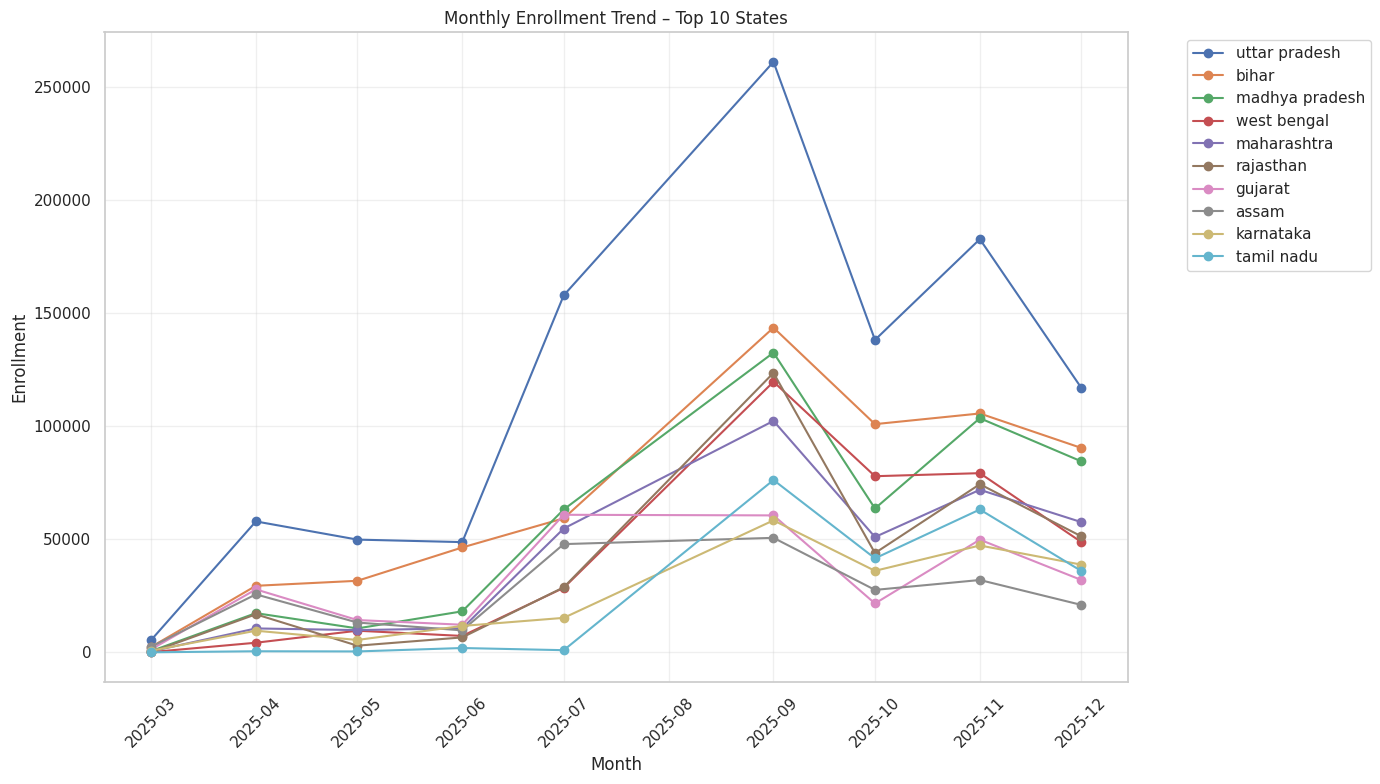

In [ ]:
state_month = enrollment.groupby(
    ['state', 'month']
)['total_enrollment'].sum().reset_index()

state_month['month'] = state_month['month'].dt.to_timestamp()

top_states = enrollment.groupby('state')['total_enrollment'] \
    .sum().nlargest(10).index

plt.figure(figsize=(14, 8))

for state in top_states:
    data = state_month[state_month['state'] == state]
    plt.plot(data['month'], data['total_enrollment'], marker='o', label=state)

plt.title('Monthly Enrollment Trend – Top 10 States')
plt.xlabel('Month')
plt.ylabel('Enrollment')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


1. **Time-Series Preparation:**
   Enrollment data is aggregated at the **state–month level**, and the month column is converted into a timestamp format to support accurate time-series analysis.

2. **Comparative Trend Analysis:**
   A multi-line chart visualizes **monthly enrollment trends for the top 10 states**, allowing direct comparison of enrollment growth and seasonal patterns across states.


### Seasonal Patterns (Top 15 States)

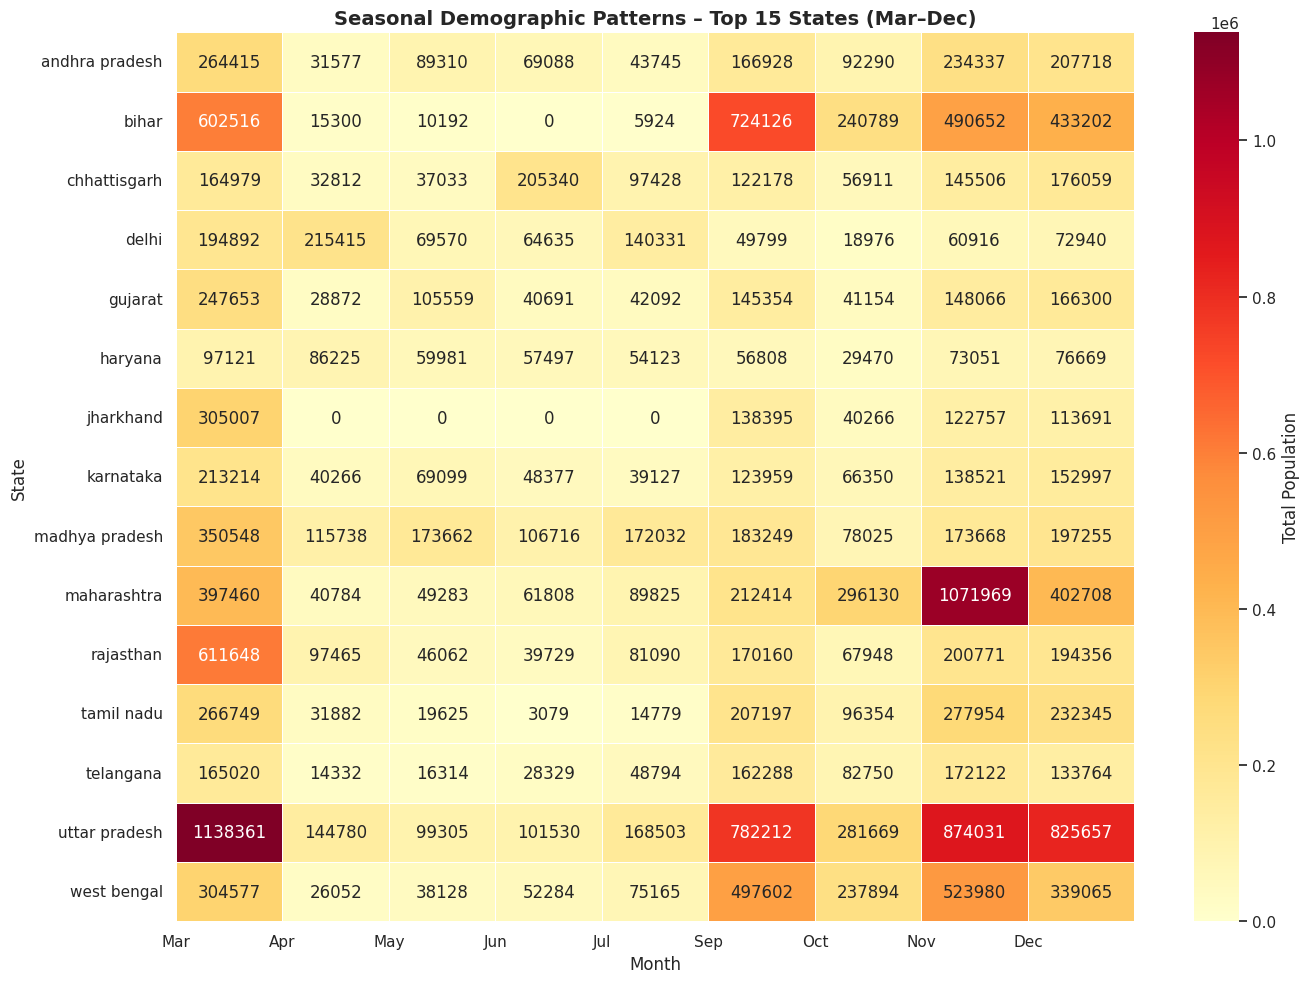

In [ ]:
# Aggregate monthly population by state
monthly_activity = demographic.groupby(
    ['state', 'month']
)['total_population'].sum().reset_index()

# Top 15 states by total population
top_states = (
    demographic.groupby('state')['total_population']
    .sum()
    .nlargest(15)
    .index
)

# Filter top states
monthly_top = monthly_activity[
    monthly_activity['state'].isin(top_states)
]

# Pivot table
heatmap_data = monthly_top.pivot_table(
    index='state',
    columns='month',
    values='total_population',
    fill_value=0
)

# Keep only Mar–Dec
heatmap_data = heatmap_data.reindex(columns=range(3, 13), fill_value=0)

# 🔥 REMOVE EMPTY MONTHS (like August)
heatmap_data = heatmap_data.loc[:, heatmap_data.sum(axis=0) > 0]

# Month label mapping
month_map = {
    3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
    7: 'Jul', 8: 'Aug', 9: 'Sep',
    10: 'Oct', 11: 'Nov', 12: 'Dec'
}
month_labels = [month_map[m] for m in heatmap_data.columns]

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(
    heatmap_data,
    cmap='YlOrRd',
    annot=True,
    fmt='.0f',
    linewidths=0.5,
    cbar_kws={'label': 'Total Population'}
)

plt.title('Seasonal Demographic Patterns – Top 15 States (Mar–Dec)',
          fontsize=14, fontweight='bold')
plt.xlabel('Month')
plt.ylabel('State')
plt.xticks(
    ticks=range(len(month_labels)),
    labels=month_labels,
    rotation=0
)

plt.tight_layout()
plt.show()


1. **Monthly Population Aggregation:**
   The demographic data is aggregated at the **state–month level** to compute total population activity, and the **top 15 states** are selected based on overall population.

2. **Heatmap Data Preparation:**
   The data is reshaped into a **pivot table** suitable for heatmap visualization, restricted to **March–December**, and empty months with no activity are removed to ensure meaningful patterns.

3. **Seasonal Pattern Visualization:**
   A heatmap is used to highlight **seasonal demographic trends across states**, enabling quick comparison of population intensity over months using a color-gradient scale.


### Top 7 Districts of Every State

/tmp/ipython-input-557309335.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.nlargest(7, 'total_population')) \


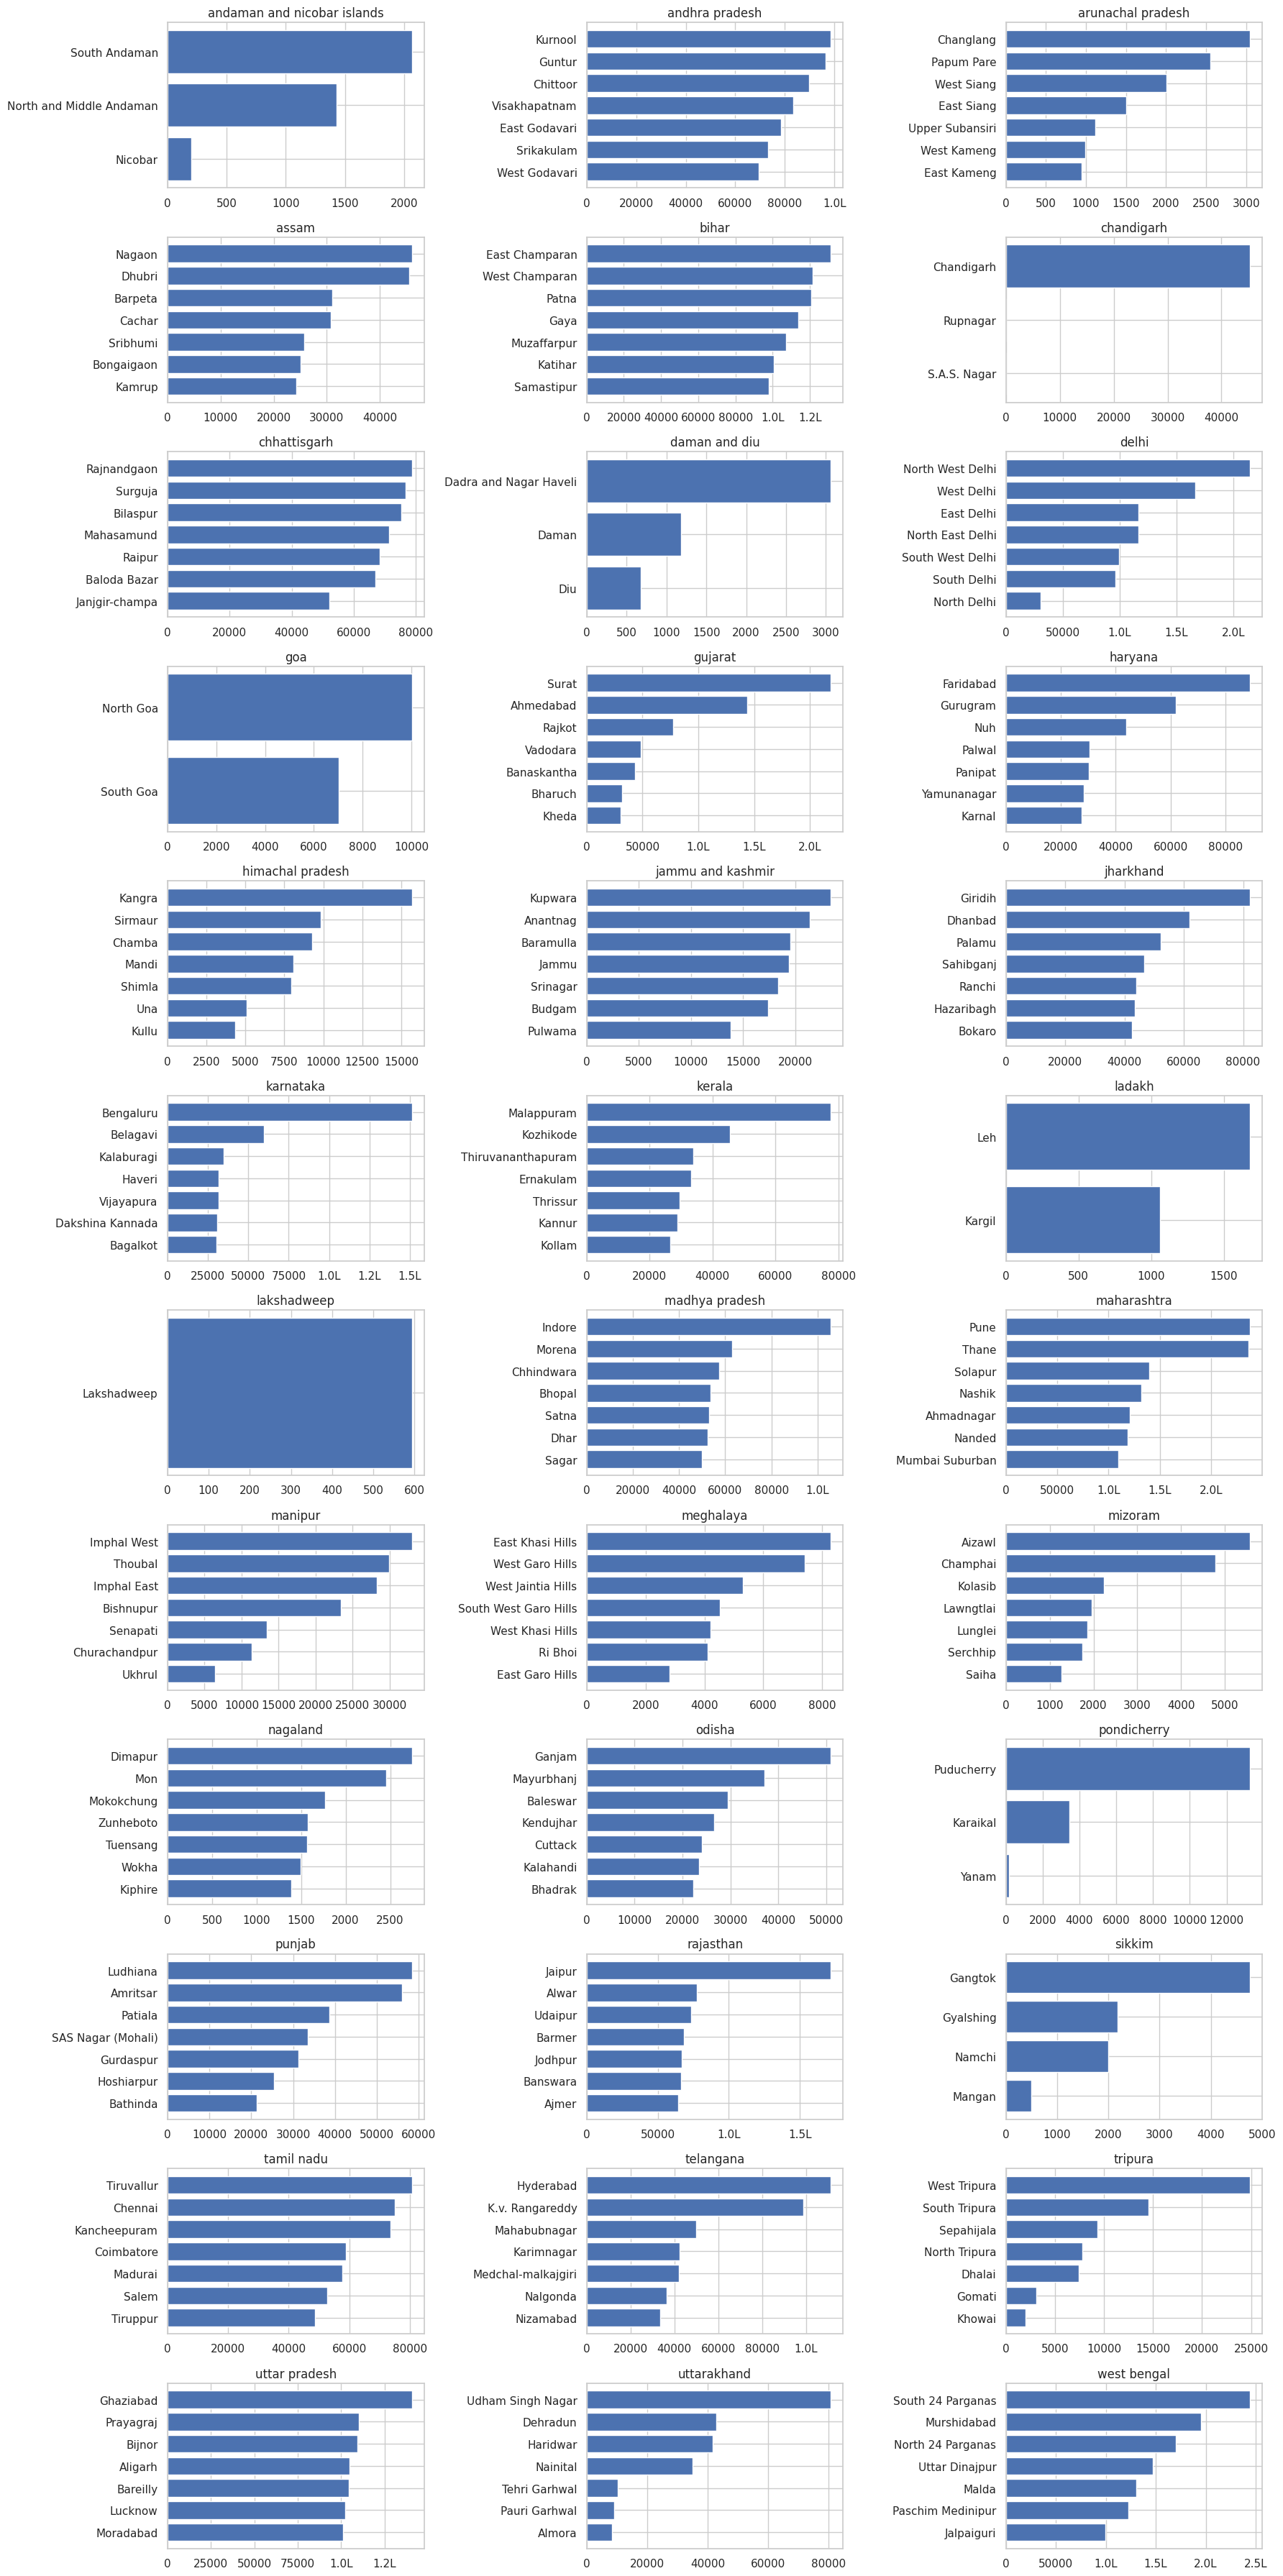

In [ ]:
district_agg = demographic.groupby(
    ['state', 'district']
)['total_population'].sum().reset_index()

top_districts_all = district_agg.groupby('state') \
    .apply(lambda x: x.nlargest(7, 'total_population')) \
    .reset_index(drop=True)

states = sorted(top_districts_all['state'].unique())
cols = 3
rows = (len(states) + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 3))
axes = axes.flatten()

for i, state in enumerate(states):
    data = top_districts_all[top_districts_all['state'] == state]
    axes[i].barh(data['district'], data['total_population'])
    axes[i].set_title(state)
    axes[i].xaxis.set_major_formatter(FuncFormatter(format_indian))
    axes[i].invert_yaxis()

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


1. **District-Level Aggregation:**
   Population data is aggregated at the **state–district level**, and the **top 7 most populated districts** are identified for each state.

2. **Dynamic Subplot Layout:**
   A flexible grid of subplots is created automatically based on the number of states, ensuring a clean and organized visualization layout.

3. **State-wise District Comparison:**
   Horizontal bar charts visualize district populations within each state, using **Indian number formatting** and inverted axes to clearly highlight the most populous districts at the top.
